# EuroSat Image Classification using ResNet

Hector Becerra  
Juan Terven  
2023

**ResNet**, short for Residual Network, is a groundbreaking convolutional neural network (CNN) architecture that revolutionized deep learning in computer vision. Introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015, it won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) that year. ResNet's defining feature is its use of *residual blocks*, which incorporate shortcut connections (or "skip connections") that allow the input of a layer to be added to its output, thereby addressing the vanishing gradient problem and enabling the training of networks with unprecedented depths, up to hundreds or even thousands of layers. This design significantly improved the accuracy of image recognition tasks and has influenced a wide range of subsequent neural network architectures, solidifying ResNet as a foundational model in deep learning.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import resnet50,ResNet50_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.12.1+cu116


## Login to Wandb to log experiment

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ResNet_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "/datasets/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

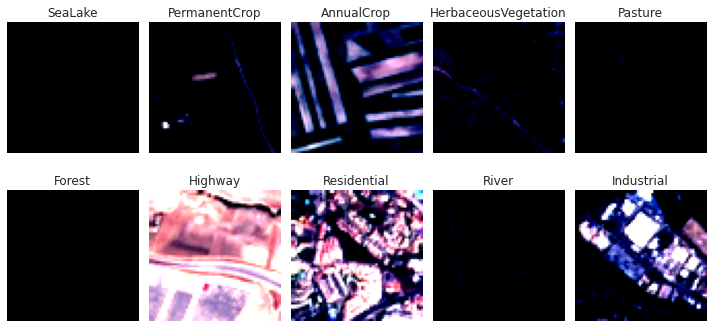

In [8]:
visualize_classes(train_loader, index_to_label)

In [9]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

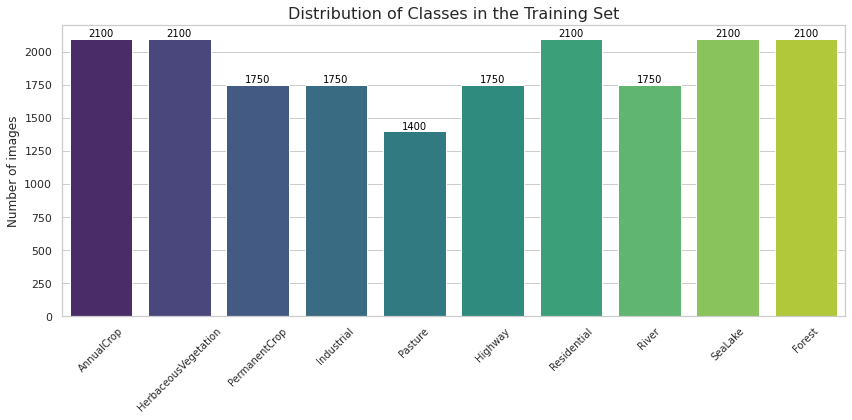

In [10]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [11]:
# Use un-pretrained model
model = resnet50()

# Replace the model head with the number of classes
num_classes = 10
model.fc = nn.Linear(2048, num_classes) 
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training model from Scratch

In [12]:
project_name = "EuroSAT"
model_name = "ResNet50"
models_path = "/datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models"

In [16]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNet from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.1419099092483522
Step: 41/296 Loss: 1.7782224535942077
Step: 61/296 Loss: 1.5874105632305144
Step: 81/296 Loss: 1.45178342461586
Step: 101/296 Loss: 1.382634276151657
Step: 121/296 Loss: 1.3059602320194243
Step: 141/296 Loss: 1.2501845151185988
Step: 161/296 Loss: 1.204709029197693
Step: 181/296 Loss: 1.1404323250055313
Step: 201/296 Loss: 1.1037502408027648
Step: 221/296 Loss: 1.18556167781353
Step: 241/296 Loss: 1.080810073018074
Step: 261/296 Loss: 0.994163379073143
Step: 281/296 Loss: 1.0291808128356934
Validation Loss: 0.9155 Accuracy: 0.6791
Epoch duration: 112.81s

Epoch: 2...
Step: 21/296 Loss: 1.2325491696596145
Step: 41/296 Loss: 1.2674286782741546
Step: 61/296 Loss: 0.9854350537061691
Step: 81/296 Loss: 1.1133081078529359
Step: 101/296 Loss: 1.0866395711898804
Step: 121/296 Loss: 0.9208508312702179
Step: 141/296 Loss: 0.9699844062328339
Step: 161/296 Loss: 0.86997

Step: 41/296 Loss: 0.2774669773876667
Step: 61/296 Loss: 0.34479950591921804
Step: 81/296 Loss: 0.30255731418728826
Step: 101/296 Loss: 0.2765438877046108
Step: 121/296 Loss: 0.2683507718145847
Step: 141/296 Loss: 0.3906727209687233
Step: 161/296 Loss: 0.3519929625093937
Step: 181/296 Loss: 0.34712557792663573
Step: 201/296 Loss: 0.3333795502781868
Step: 221/296 Loss: 0.3372501596808434
Step: 241/296 Loss: 0.3482023410499096
Step: 261/296 Loss: 0.3697226457297802
Step: 281/296 Loss: 0.40186168551445006
Validation Loss: 0.4814 Accuracy: 0.8352
Epoch duration: 74.08s

Epoch: 15...
Step: 21/296 Loss: 0.2666990030556917
Step: 41/296 Loss: 0.2824180983006954
Step: 61/296 Loss: 0.30531009659171104
Step: 81/296 Loss: 0.3123067654669285
Step: 101/296 Loss: 0.28546382188797
Step: 121/296 Loss: 0.285787770152092
Step: 141/296 Loss: 0.2565293423831463
Step: 161/296 Loss: 0.2641175851225853
Step: 181/296 Loss: 0.26929831206798555
Step: 201/296 Loss: 0.23161047510802746
Step: 221/296 Loss: 0.278312

Step: 81/296 Loss: 0.10389509182423354
Step: 101/296 Loss: 0.15498247258365155
Step: 121/296 Loss: 0.14842576403170823
Step: 141/296 Loss: 0.13001281023025513
Step: 161/296 Loss: 0.1357271283864975
Step: 181/296 Loss: 0.13615522310137748
Step: 201/296 Loss: 0.1432508010417223
Step: 221/296 Loss: 0.12727388758212327
Step: 241/296 Loss: 0.15243795625865458
Step: 261/296 Loss: 0.15388964470475913
Step: 281/296 Loss: 0.24619276635348797
Validation Loss: 0.6058 Accuracy: 0.8333
Epoch duration: 70.32s

Epoch: 28...
Step: 21/296 Loss: 0.10009287223219872
Step: 41/296 Loss: 0.10817864220589399
Step: 61/296 Loss: 0.11826954167336226
Step: 81/296 Loss: 0.1436682863160968
Step: 101/296 Loss: 0.10880670920014382
Step: 121/296 Loss: 0.08025895282626153
Step: 141/296 Loss: 0.09629570702090859
Step: 161/296 Loss: 0.14330928605049847
Step: 181/296 Loss: 0.14667159505188465
Step: 201/296 Loss: 0.12032873574644327
Step: 221/296 Loss: 0.09354796493425965
Step: 241/296 Loss: 0.16475843898952008
Step: 261/

Step: 81/296 Loss: 0.08073832569643855
Step: 101/296 Loss: 0.06307175885885954
Step: 121/296 Loss: 0.074239935958758
Step: 141/296 Loss: 0.06424751812592149
Step: 161/296 Loss: 0.07952567832544447
Step: 181/296 Loss: 0.08863666281104088
Step: 201/296 Loss: 0.07142767622135579
Step: 221/296 Loss: 0.07397885015234351
Step: 241/296 Loss: 0.11715005589649082
Step: 261/296 Loss: 0.1100154122337699
Step: 281/296 Loss: 0.08256768975406885
Validation Loss: 0.6189 Accuracy: 0.8500
Epoch duration: 70.39s

Epoch: 41...
Step: 21/296 Loss: 0.07413032990880311
Step: 41/296 Loss: 0.05675351438112557
Step: 61/296 Loss: 0.08617345730308443
Step: 81/296 Loss: 0.1813023048453033
Step: 101/296 Loss: 0.09875658340752125
Step: 121/296 Loss: 0.06887223804369569
Step: 141/296 Loss: 0.06482478007674217
Step: 161/296 Loss: 0.05825264067389071
Step: 181/296 Loss: 0.08397492319345475
Step: 201/296 Loss: 0.09499604185111821
Step: 221/296 Loss: 0.12037769490852952
Step: 241/296 Loss: 0.11730069387704134
Step: 261/2

Step: 61/296 Loss: 0.07437469647265971
Step: 81/296 Loss: 0.05960357978474349
Step: 101/296 Loss: 0.025507424143142998
Step: 121/296 Loss: 0.03287068816134706
Step: 141/296 Loss: 0.04790194963570684
Step: 161/296 Loss: 0.04053444252349436
Step: 181/296 Loss: 0.02406736375996843
Step: 201/296 Loss: 0.0312203614768805
Step: 221/296 Loss: 0.03696173205971718
Step: 241/296 Loss: 0.028985058498801664
Step: 261/296 Loss: 0.11076732014771551
Step: 281/296 Loss: 0.16104835141450166
Validation Loss: 0.6866 Accuracy: 0.8383
Epoch duration: 69.52s

Epoch: 54...
Step: 21/296 Loss: 0.0718392952810973
Step: 41/296 Loss: 0.06606607977300882
Step: 61/296 Loss: 0.05427385233342648
Step: 81/296 Loss: 0.03499640114605427
Step: 101/296 Loss: 0.04590706187300384
Step: 121/296 Loss: 0.03126813492272049
Step: 141/296 Loss: 0.05633213874534704
Step: 161/296 Loss: 0.06493604648858309
Step: 181/296 Loss: 0.04594800963532179
Step: 201/296 Loss: 0.10936776199378073
Step: 221/296 Loss: 0.08312912182882429
Step: 24

## Save model

In [17]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-ResNet50.pth


In [18]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

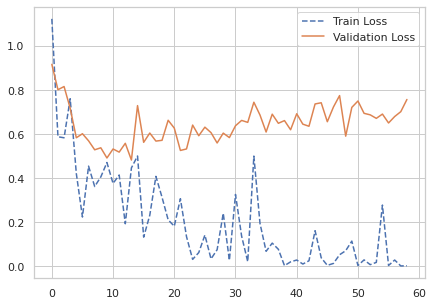

In [19]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [13]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ResNet50.pth


<All keys matched successfully>

In [14]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.871     0.880     0.876       300
              Forest      0.813     0.987     0.892       300
HerbaceousVegetation      0.748     0.780     0.763       300
             Highway      0.731     0.664     0.696       250
          Industrial      0.941     0.892     0.916       250
             Pasture      0.869     0.795     0.830       200
       PermanentCrop      0.658     0.776     0.712       250
         Residential      0.956     0.943     0.950       300
               River      0.801     0.756     0.778       250
             SeaLake      1.000     0.820     0.901       300

            accuracy                          0.835      2700
           macro avg      0.839     0.829     0.831      2700
        weighted avg      0.842     0.835     0.836      2700



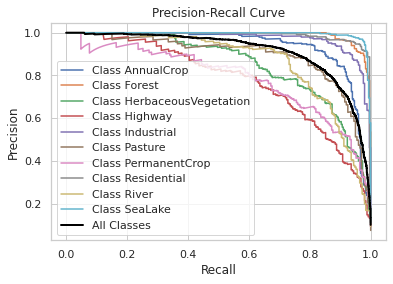

In [21]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [22]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▅▅▆▆▆▇▇▄▆▆▆▇█▇▇▇██▇▇▇██▇███▆▇█▇▇▇█▇█▇
val_loss,█▆▆▃▃▂▂▂▂▁▅▃▂▄▃▂▄▃▃▃▃▄▄▄▃▄▄▄▄▅▅▅▆▅▅▄▄▄▄▅
epoch,58
step,17448
train_loss,0.06644
val_accuracy,0.82722
val_loss,0.75621


## Load the precision/recall curve and plot it

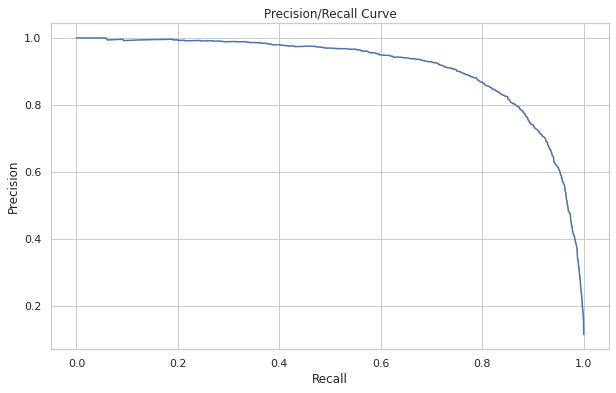

In [23]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [15]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26125

# Now train the model with pre-trained weights

In [17]:
# Use pretrained model
model2=resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.fc = nn.Linear(2048, num_classes) 
model2.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train

In [20]:
model_name = "ResNet50-Pretrained"

In [26]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNet pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.3121710434556006
Step: 41/296 Loss: 0.3828035183250904
Step: 61/296 Loss: 0.26007808484137057
Step: 81/296 Loss: 0.25632433257997034
Step: 101/296 Loss: 0.18500524275004865
Step: 121/296 Loss: 0.21168725900352
Step: 141/296 Loss: 0.20327800158411263
Step: 161/296 Loss: 0.20402067191898823
Step: 181/296 Loss: 0.1872485311701894
Step: 201/296 Loss: 0.15828113928437232
Step: 221/296 Loss: 0.1594890547916293
Step: 241/296 Loss: 0.16458846740424632
Step: 261/296 Loss: 0.16222392283380033
Step: 281/296 Loss: 0.1631573020480573
Validation Loss: 0.1076 Accuracy: 0.9657
Epoch duration: 111.47s

Epoch: 2...
Step: 21/296 Loss: 0.0972707647830248
Step: 41/296 Loss: 0.20747339874505996
Step: 61/296 Loss: 0.1777623461559415
Step: 81/296 Loss: 0.21529540233314037
Step: 101/296 Loss: 0.18734726291149856
Step: 121/296 Loss: 0.1544705169275403
Step: 141/296 Loss: 0.2230492800474167
Step: 161/

## Save model

In [27]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-ResNet-Pretrained.pth


In [28]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

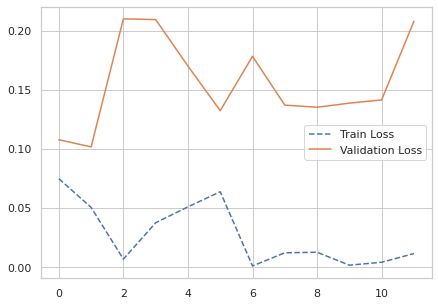

In [29]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [21]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ResNet50-Pretrained.pth


<All keys matched successfully>

In [22]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.927     0.973     0.950       300
              Forest      0.931     0.993     0.961       300
HerbaceousVegetation      0.979     0.773     0.864       300
             Highway      0.953     0.980     0.966       250
          Industrial      1.000     0.968     0.984       250
             Pasture      0.988     0.830     0.902       200
       PermanentCrop      0.799     0.968     0.875       250
         Residential      0.987     0.997     0.992       300
               River      0.942     0.968     0.955       250
             SeaLake      1.000     0.993     0.997       300

            accuracy                          0.947      2700
           macro avg      0.951     0.944     0.945      2700
        weighted avg      0.951     0.947     0.946      2700



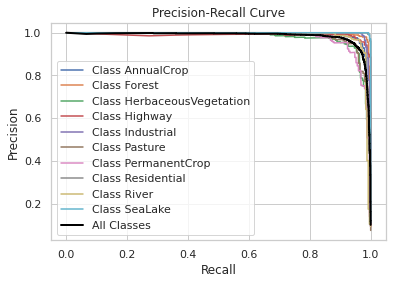

In [31]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [32]:
wandb.finish()

epoch,▁▂▂▃▄▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▄▄▅▃▂▂▃▂▂▂▂▂▁▂▂▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▁▁▂▂▁▂
val_accuracy,▇█▁▃▄▇▅█▇█▇▂
val_loss,▁▁██▅▃▆▃▃▃▄█
epoch,11
step,3536
train_loss,0.08006
val_accuracy,0.94167
val_loss,0.20783


In [23]:
del model2
torch.cuda.empty_cache()
gc.collect()

821